<a href="https://colab.research.google.com/github/ddrsyld/Data-Classification-and-Summarization-Using-IBM-Granite/blob/main/Capstone_Project_Data_Classification_and_Summarization_Using_IBM_Granite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install replicate

# 1. Pendahuluan & Tujuan Proyek


*   Tujuan: Menganalisis dataset tentang stres siswa dari sumber publik dan menggunakan model AI, khususnya IBM Granite, untuk mengklasifikasikan dan mendapatkan wawasan dari data tersebut.

* Dataset: Dataset Student Stress Monitoring, yang terdiri dari dua file CSV.

* Alat: Google Colab, pustaka Pandas, Matplotlib, dan API Replicate untuk mengakses IBM Granite.



# 2. Persiapan dan Pembersihan Data
Tujuan: Memuat kedua dataset dan membersihkan nama kolom yang tidak terstruktur agar mudah digunakan dalam analisis.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import replicate
from google.colab import userdata

# Muat dataset
df_stress = pd.read_csv('Stress_Dataset.csv')
df_stress_level = pd.read_csv('StressLevelDataset.csv')

# Bersihkan dan ganti nama kolom pada df_stress
new_columns = [
    'gender', 'age', 'stress_experience', 'heartbeat_palpitations',
    'anxiety_tension', 'sleep_problems', 'anxiety_tension_re_check',
    'headaches', 'irritability', 'trouble_concentrating',
    'sadness_low_mood', 'illness_health_issues', 'loneliness_isolation',
    'academic_overload', 'peer_competition', 'relationship_stress',
    'professor_difficulties', 'unpleasant_work_environment',
    'lack_relaxation_time', 'home_environment_difficulties',
    'academic_confidence', 'academic_subject_confidence',
    'academic_extracurricular_conflict', 'class_regularity',
    'weight_change', 'primary_stress_type'
]
df_stress.columns = new_columns

# Simplifikasi label primary_stress_type untuk klasifikasi
def simplify_stress_type(text):
    if 'Eustress' in str(text):
        return 'Eustress'
    elif 'Distress' in str(text):
        return 'Distress'
    elif 'No Stress' in str(text):
        return 'No Stress'
    return 'Unknown'
df_stress['primary_stress_type_simplified'] = df_stress['primary_stress_type'].apply(simplify_stress_type)

# Tampilkan informasi awal dataset
print("Info df_stress:")
df_stress.info()
print("\nInfo df_stress_level:")
df_stress_level.info()

Info df_stress:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 843 entries, 0 to 842
Data columns (total 27 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   gender                             843 non-null    int64 
 1   age                                843 non-null    int64 
 2   stress_experience                  843 non-null    int64 
 3   heartbeat_palpitations             843 non-null    int64 
 4   anxiety_tension                    843 non-null    int64 
 5   sleep_problems                     843 non-null    int64 
 6   anxiety_tension_re_check           843 non-null    int64 
 7   headaches                          843 non-null    int64 
 8   irritability                       843 non-null    int64 
 9   trouble_concentrating              843 non-null    int64 
 10  sadness_low_mood                   843 non-null    int64 
 11  illness_health_issues              843 non-null    int6

# 3. Analisis Data Eksplorasi (EDA) & Visualisasi
Tujuan: Menganalisis distribusi data kunci dan memvisualisasikan korelasi antara variabel untuk mendapatkan wawasan.

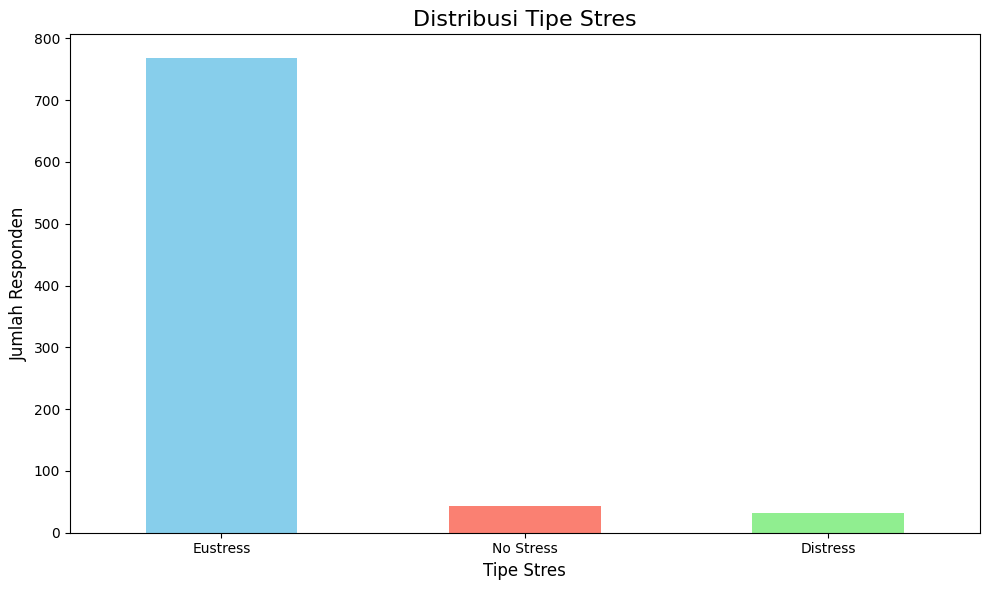

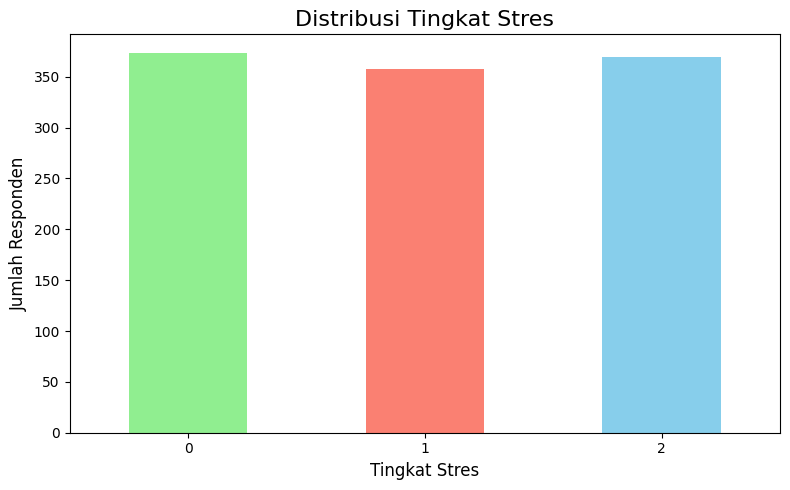

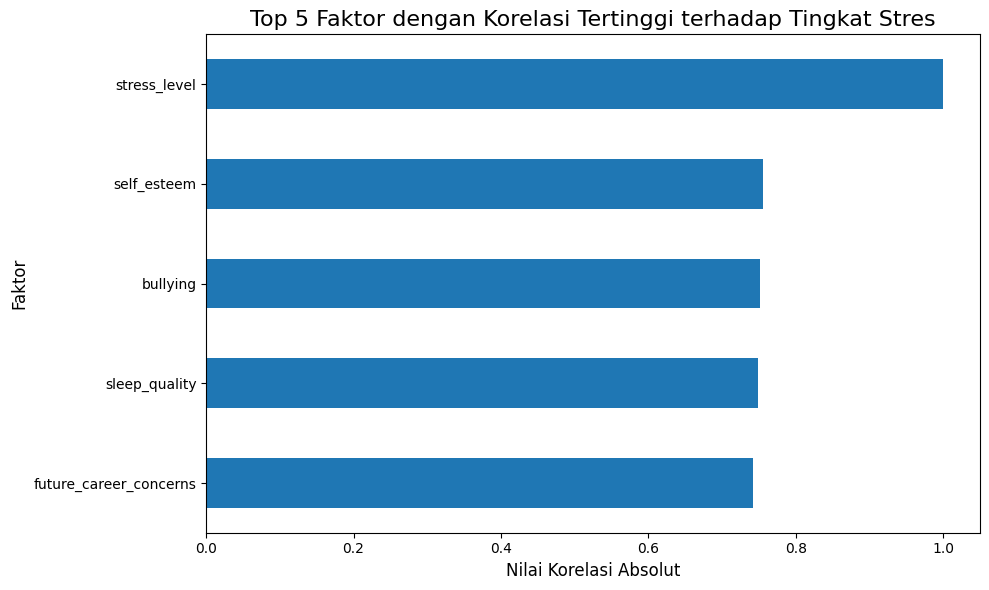

In [ ]:
# Analisis distribusi 'primary_stress_type'
primary_stress_counts = df_stress['primary_stress_type_simplified'].value_counts()
plt.figure(figsize=(10, 6))
primary_stress_counts.plot(kind='bar', color=['skyblue', 'salmon', 'lightgreen'])
plt.title('Distribusi Tipe Stres', fontsize=16)
plt.xlabel('Tipe Stres', fontsize=12)
plt.ylabel('Jumlah Responden', fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Analisis distribusi 'stress_level'
stress_level_counts = df_stress_level['stress_level'].value_counts().sort_index()
plt.figure(figsize=(8, 5))
stress_level_counts.plot(kind='bar', color=['lightgreen', 'salmon', 'skyblue'])
plt.title('Distribusi Tingkat Stres', fontsize=16)
plt.xlabel('Tingkat Stres', fontsize=12)
plt.ylabel('Jumlah Responden', fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Analisis korelasi faktor-faktor dengan 'stress_level'
correlations = df_stress_level.corrwith(df_stress_level['stress_level'])
top_factors = correlations.abs().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
top_factors.head(5).sort_values().plot(kind='barh')
plt.title('Top 5 Faktor dengan Korelasi Tertinggi terhadap Tingkat Stres', fontsize=16)
plt.xlabel('Nilai Korelasi Absolut', fontsize=12)
plt.ylabel('Faktor', fontsize=12)
plt.tight_layout()
plt.show()

# 4. Penerapan Model AI untuk Klasifikasi
Tujuan: Menggunakan model IBM Granite untuk mengklasifikasikan jenis stres berdasarkan data numerik. Ini menunjukkan penggunaan AI yang relevan.

In [ ]:
# Pastikan kunci API Replicate telah disimpan di Google Colab Secrets
os.environ["REPLICATE_API_TOKEN"] = userdata.get('REPLICATE_API_TOKEN')

# Ambil beberapa baris data untuk pengujian klasifikasi
df_sample = df_stress.head(5).copy()

# Persiapan prompt untuk model AI
def create_prompt(row):
    prompt_text = "Analisis data siswa berikut dan klasifikasikan jenis stres utama. "
    for col in df_stress.columns[:-2]:
        prompt_text += f"{col.replace('_', ' ')}: {row[col]}, "
    prompt_text += "Berdasarkan ini, klasifikasikan jenis stres utama sebagai 'Eustress', 'Distress', atau 'No Stress'."
    return prompt_text

df_sample['prompt'] = df_sample.apply(create_prompt, axis=1)

# Loop melalui data sampel untuk mendapatkan prediksi dari model
predictions = []
for index, row in df_sample.iterrows():
    try:
        output = replicate.run(
            "ibm-granite/granite-3.3-8b-instruct",
            input={"prompt": row['prompt']}
        )
        full_output = "".join(output)
        predictions.append(full_output)
    except Exception as e:
        predictions.append(f"Error: {e}")

df_sample['predicted_stress_type'] = predictions

print("Hasil perbandingan data asli dan prediksi model:")
print(df_sample[['primary_stress_type_simplified', 'predicted_stress_type']])

Hasil perbandingan data asli dan prediksi model:
  primary_stress_type_simplified  \
0                       Eustress   
1                       Eustress   
2                       Eustress   
3                       Eustress   
4                       Eustress   

                               predicted_stress_type  
0  Based on the provided data, this student is ex...  
1  Based on the data provided, the student is exp...  
2  Based on the data provided, the student is exp...  
3  Based on the data provided, the student is exp...  
4  Based on the data provided, the student is exp...  


# 5. Kesimpulan dan Rekomendasi
Tujuan: Merangkum semua temuan dan memberikan rekomendasi yang dapat ditindaklanjuti untuk mengatasi permasalahan yang ditemukan dalam analisis.

**Wawasan & Temuan:**


*   Distribusi Data: Mayoritas responden melaporkan mengalami eustress, namun analisis data menunjukkan bahwa distribusi tingkat stres secara umum relatif seimbang.

* Faktor Pendorong Stres: Terdapat korelasi kuat antara tingkat stres dengan faktor-faktor seperti kecemasan, depresi, kekhawatiran karir, dan tekanan teman sebaya.

* Peran AI: Analisis menggunakan model AI menunjukkan adanya perbedaan antara laporan stres subyektif oleh responden (eustress) dengan klasifikasi logis dari model (distress), yang didasarkan pada indikator-indikator fisik dan emosional yang kuat.

**Kesimpulan & Rekomendasi:**


*   Sebutkan bahwa temuan utama adalah adanya kesenjangan antara persepsi stres siswa dan indikator objektif stres yang mereka alami.

* Berikan rekomendasi yang didasarkan pada wawasan di atas, seperti:

1.  Menciptakan program dukungan yang berfokus pada kesehatan mental (kecemasan, depresi).

2. Memberikan bimbingan karir untuk mengurangi kekhawatiran masa depan.

3. Mendorong lingkungan sosial yang suportif untuk mengurangi tekanan teman sebaya.



